In [1]:
#import paper_plots as carlosplt
from pymongo import MongoClient
import stat_tests as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json
import csv
from matplotlib.font_manager import FontProperties
import seaborn as sns
import laplace_tests as lptests
import statsmodels.api as sm
import datetime
import powerlaw
import re

In [2]:
with open('./vendors/debian/cache/src2dsa') as fp:
    src2dsa=json.load(fp)
with open('./vendors/debian/cache/dsa2cve') as fp:
    dsa2cve=json.load(fp)
with open('./vendors/debian/cache/src2month') as fp:
    src2month=json.load(fp)
with open('./vendors/debian/cache/pkg_with_cvss') as fp:
    pkg_with_cvss=json.load(fp)
with open('./vendors/debian/cache/dsainfo') as fp:
    dsainfo=json.load(fp)
with open('./vendors/debian/cache/src2sloccount') as fp:
    src2sloccount=json.load(fp)
with open('./vendors/debian/src2month_DLA.json') as fp:
    src2dla=json.load(fp)
with open('./cwe_roots.json') as fp:
    cwe_roots=json.load(fp)

client = MongoClient('mongodb://localhost:27017/')
db = client.cvedb

# Get the collection object
# Here name of the database is "states"

collection  = db.cves

# Make a query to list all the documents

cvedicttemp=collection.find()

In [3]:
cvedict=dict()
for key in cvedicttemp:
    cvedict[key['id']]=key

In [4]:
single_src2month=dict()
single_pkg_with_cvss=dict()

In [5]:
# Number counted once
cve_once=dict()
repeat_count=dict()
for dsa in dsa2cve:
    for cve in dsa2cve[dsa]:
        if cve not in cve_once:
            date1=dsainfo[dsa][1]
            date1 = datetime.datetime.strptime(date1, '%Y-%m-%d %H:%M:%S')
            try:
                date2=cvedict[cve]['Published']
                if date1<date2:
                    date=date1
                else:
                    date=date2
                cve_once[cve]=date
                repeat_count[cve]=[date1]
                continue
            except KeyError:
                cve_once[cve]=date1
                repeat_count[cve]=[date1]
                continue
        if cve in cve_once:
            date1=dsainfo[dsa][1]
            date1 = datetime.datetime.strptime(date1, '%Y-%m-%d %H:%M:%S')
            date2=cve_once[cve]
            if date1<date2:
                date=date1
            else:
                date=date2    
            cve_once[cve]=date
            repeat_count[cve].append(date1)

In [6]:
cve2src=dict()
for cve in cve_once:
    cve2src[cve]=[]
    for src in src2dsa:
        for dsa in src2dsa[src]:
            if cve in dsa2cve[str(dsa)]:
                if src not in cve2src[cve]:
                    cve2src[cve].append(src)

In [7]:
# Here we start the plotting        
years=18

num_low = [0] * (years+1) * 12
num_med = [0] * (years+1) * 12
num_high = [0] * (years+1) * 12
num_udef = [0] * (years+1) * 12
total = [0] * (years+1) * 12
for i in cve_once:
    year = cve_once[i].year
    month = cve_once[i].month
    index = (year-2000)*12+month-1
    if year-2000 > years:
        continue
    total[index] += 1
    try:
        cvss=cvedict[i]['cvss']
        if cvss<0.0 or cvss>10.0:
            print('Unexpected')
            num_udef[index] += 1
        if cvss<4.0:        
            num_low[index] += 1
        elif cvss<7.0:
            num_med[index] += 1
        else:    
            num_high[index] += 1
    except:
        num_udef[index] += 1
print(total)
print(sum(total))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 4, 13, 17, 5, 9, 6, 5, 4, 7, 5, 7, 7, 12, 14, 3, 1, 14, 9, 29, 17, 23, 27, 32, 31, 8, 42, 21, 16, 36, 26, 22, 29, 7, 9, 13, 29, 26, 21, 27, 12, 20, 14, 36, 21, 25, 20, 45, 59, 30, 19, 31, 40, 21, 54, 62, 59, 66, 56, 73, 26, 36, 35, 81, 45, 42, 46, 51, 40, 19, 26, 38, 19, 22, 50, 43, 40, 59, 47, 25, 45, 38, 45, 35, 38, 50, 46, 36, 31, 28, 41, 30, 46, 32, 36, 43, 37, 34, 67, 66, 35, 50, 46, 35, 53, 47, 41, 45, 34, 49, 17, 27, 21, 44, 39, 57, 35, 31, 41, 37, 60, 47, 81, 40, 65, 38, 41, 47, 36, 47, 27, 29, 69, 48, 45, 35, 41, 59, 42, 49, 25, 40, 37, 19, 27, 41, 60, 47, 77, 88, 61, 47, 45, 65, 67, 66, 54, 65, 69, 90, 44, 38, 66, 57, 40, 95, 60, 80, 70, 68, 65, 93, 73, 55, 91, 69, 60, 86, 69, 73, 115, 99, 115, 91, 99, 86, 111, 114, 104, 42, 64, 106, 172, 73, 106, 113, 68, 86, 146, 141, 198, 106, 95, 106, 117, 67, 93, 161, 56, 79, 95, 42, 59, 54, 51, 82]
10716


[0, 0.07692307692307693, 0.1276595744680851, 0.09615384615384616, 0.11148648648648649, 0.03333333333333333, 0.07422680412371134, 0.014957264957264958, 0.002188183807439825, 0.012589928057553957, 0.037037037037037035, 0.012544802867383513, 0.003929273084479371, 0.004341534008683068, 0.021108179419525065, 0.0389908256880734, 0.005235602094240838, 0.002127659574468085, 0.0041841004184100415]


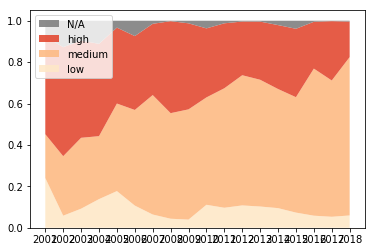

In [8]:
# Plot severity percentage
pal = ['#fee8c8', '#fdbb84', '#e34a33', 'grey']
x = range(2001, 2001 + years)

per_low = [0] * (years+1)
per_med = [0] * (years+1)
per_high = [0] * (years+1)
per_udef = [0] * (years+1)

labels_cvss = ['low', 'medium', 'high', 'N/A']
        
for i in range(years + 1):
    try:
        per_low[i] = sum(num_low[i*12:i*12+12])/sum(total[i*12:i*12+12])
        per_med[i] = sum(num_med[i*12:i*12+12])/sum(total[i*12:i*12+12])
        per_high[i] = sum(num_high[i*12:i*12+12])/sum(total[i*12:i*12+12])
        per_udef[i] = sum(num_udef[i*12:i*12+12])/sum(total[i*12:i*12+12])
    except ZeroDivisionError:
        per_low[i] = 0
        per_med[i] = 0
        per_high[i] = 0
        per_udef[i] = 0

h = plt.stackplot(x, [per_low[1:], per_med[1:], per_high[1:], per_udef[1:]], colors = pal, alpha=0.9, labels = labels_cvss)
plt.xticks(x)
plt.legend(loc='upper left', handles = h[::-1])
#carlosplt.post_paper_plot(True,True,True)
print(per_udef)
plt.show()

In [9]:
# Next we filter the vulnerabilities by severity (for use later)
#carlosplt.pre_paper_plot()
l=0
m=0
h=1
udef=0

filtered=[0]*len(total)
        
for i in range(len(total)):
    tempp=0
    if l:
        tempp += num_low[i]
    if m:
        tempp += num_med[i]
    if h:
        tempp += num_high[i]
    if udef:
        tempp += num_udef[i]
    filtered[i]+=tempp  

linux :  948 2 ('linux', 160)
chromium-browser :  799 1 ('chromium-browser', 303)
firefox-esr :  739 3 ('firefox-esr', 147)
icedove :  600 5 ('icedove', 127)
php7 :  386 19 ('php7', 28)
openjdk :  309 7 ('openjdk', 89)
wireshark :  303 14 ('wireshark', 43)
xulrunner :  211 833 ('xulrunner', 0)
mysql-transitional :  209 12 ('mysql-transitional', 47)
imagemagick :  195 6 ('imagemagick', 99)
iceape :  178 831 ('iceape', 0)
xen :  172 8 ('xen', 59)
tcpdump :  156 4 ('tcpdump', 131)
wordpress :  147 13 ('wordpress', 46)
openssl :  134 29 ('openssl', 13)
tiff :  127 10 ('tiff', 55)
qemu :  121 16 ('qemu', 36)
mariadb-10.1 :  116 11 ('mariadb-10.1', 51)
ruby2.3 :  84 15 ('ruby2.3', 39)
graphicsmagick :  82 9 ('graphicsmagick', 56)
one_only =  597
one_plus =  681
Total number of packages =  1278
Total:  12192


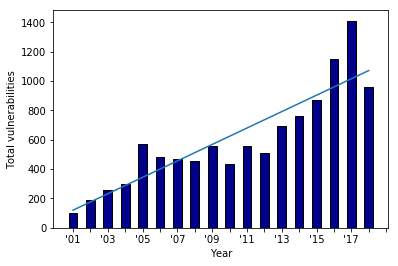

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     62.36
Date:                Thu, 31 Oct 2019   Prob (F-statistic):           6.56e-07
Time:                        13:38:55   Log-Likelihood:                -115.36
No. Observations:                  18   AIC:                             234.7
Df Residuals:                      16   BIC:                             236.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        120.0175     70.519      1.702      0.1

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


In [10]:
# We look at vulnerabilities per package

src2sum = dict()
src2year = dict()
src2lastyears = dict()
src2dens = dict()
src2month_temp = dict()
year_sum = [0]*(years+1)
year_num = [0]*(years+1)

for src in src2dsa:
    src2year[src]=[0]*(years+1)

for cve in cve_once:
    try:
        year=cve_once[cve].year
        month=cve_once[cve].month
        pkgs=cve2src[cve]
    except KeyError:
        continue
    if year-2000 > years:
        continue
    year_sum[year-2000]+=1
    for pkg in pkgs:
        src2year[pkg][year-2000]+=1 

for src in src2year:
    src2sum[src]=sum(src2year[src])
    src2lastyears[src]=sum(src2year[src][-2:])
    i=0
    for num in src2year[src]:
        if num>0:
            year_num[i]+=1
        i+=1
    
# Print top 20 packages in total and last 2 year (2017-2018)
sorted_x = sorted(src2sum.items(), key=lambda kv: kv[1], reverse=True)
sorted_y = sorted(src2lastyears.items(), key=lambda kv: kv[1], reverse=True)
for i in sorted_x[:20]:
    pkg=i[0]
    rank_last=1
    for j in sorted_y:
        if j[0]==pkg:
            break
        else:
            rank_last+=1
    print(pkg, ': ', i[1], rank_last, sorted_y[rank_last-1] )
        
#calc total
one_only=0
one_plus=0
for src in src2year:
    if sum(src2year[src])==1:
        one_only+=1
    elif sum(src2year[src])>1:
        one_plus+=1
        
print('one_only = ', one_only)
print('one_plus = ', one_plus)
print('Total number of packages = ', one_only+one_plus)


values = sorted(src2sum.values(),reverse=True)
#print(values)
keys = list(sorted(src2sum, key=src2sum.__getitem__, reverse=True))

n = len(year_sum)
yearsx = []
for i in range(1,years+1):
    if i%2==1:
        yearsx.append('\''+str(i).zfill(2))
    else:
        yearsx.append('')
    
x = range(years)
width = 1/2
plt.bar(x, year_sum[1:], width, color='darkblue', edgecolor='black')
#plt.bar(x, average_per_year, width)
plt.xticks(np.arange(0,n),yearsx)
plt.ylabel('Total vulnerabilities')
plt.xlabel('Year')
#carlosplt.post_paper_plot(True,True,True)        
sum_all = sum(values)
print("Total: ", sum_all)

## Linear regression model
X = sm.add_constant(x)
y = year_sum[1:]
model = sm.OLS(y,X).fit()
predictions = model.predict(X)
plt.plot(predictions)
plt.show()
print(model.summary())
#print(model.summary().as_latex())

[]
[]
['Totals', 'grouped', 'by', 'language', '(dominant', 'language', 'first):']
['ansic:', '95159493', '(52.99%)']
['cpp:', '32075321', '(17.86%)']
['xml:', '8909150', '(4.96%)']
['python:', '6371215', '(3.55%)']
['java:', '6264207', '(3.49%)']
['cs:', '6101424', '(3.40%)']
['perl:', '5428136', '(3.02%)']
['javascript:', '4838371', '(2.69%)']
['php:', '4169107', '(2.32%)']
['sh:', '2982339', '(1.66%)']
['asm:', '2021774', '(1.13%)']
['erlang:', '1695977', '(0.94%)']
['ruby:', '1324916', '(0.74%)']
['lisp:', '664420', '(0.37%)']
['yacc:', '311515', '(0.17%)']
['ml:', '251442', '(0.14%)']
['exp:', '224063', '(0.12%)']
['pascal:', '179741', '(0.10%)']
['tcl:', '172945', '(0.10%)']
['objc:', '149580', '(0.08%)']
['fortran:', '108806', '(0.06%)']
['lex:', '77803', '(0.04%)']
['f90:', '28907', '(0.02%)']
['awk:', '27233', '(0.02%)']
['jsp:', '17184', '(0.01%)']
['ada:', '16510', '(0.01%)']
['csh:', '14022', '(0.01%)']
['sed:', '3405', '(0.00%)']
['modula3:', '33', '(0.00%)']
[]
[]
[]
[]
['

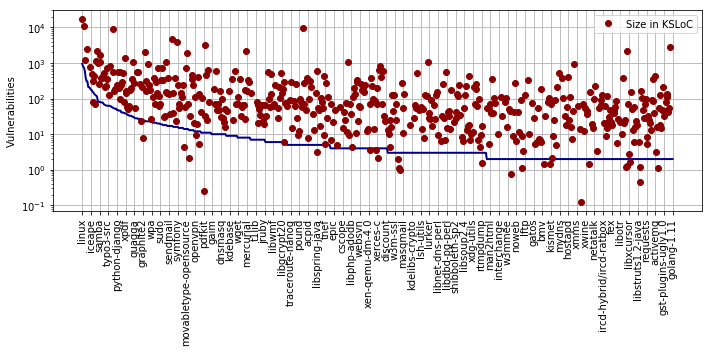

In [11]:
# The measurement originates from February 2018
with open('./sloc_report.txt') as f:
    content = f.readlines()
    for i in content:
        (total_slocs, ansic, cpp, asm, java, python, perl, sh) = (0, 0, 0, 0, 0, 0, 0, 0)
        words=i.split()
        try:
            total_slocs = int(words[0])
            pkg = words[1]
            for w in words[2:]:
                ww = re.split('=|,',w)
                if ww[0] == 'ansic':
                    ansic = int(ww[1])
                if ww[0] == 'cpp':
                    cpp = int(ww[1])
                if ww[0] == 'asm':
                    asm = int(ww[1])
                if ww[0] == 'java':
                    java = int(ww[1])
                if ww[0] == 'python':
                    python = int(ww[1])
                if ww[0] == 'perl':
                    perl = int(ww[1])
                if ww[0] == 'sh':
                    sh = int(ww[1])    
            src2sloccount[pkg] = (total_slocs, [ansic, cpp, asm, java, python, perl, sh])
        except:
            print(words)



src2sum_g2=dict()
for src in src2sum:
    if src2sum[src]>1:
        src2sum_g2[src]=src2sum[src]
values = sorted(src2sum_g2.values(),reverse=True)
#print(values)
keys = list(sorted(src2sum_g2, key=src2sum_g2.__getitem__, reverse=True))

density = []
density_keys=[]
size = []
size_dens = []

for pkg in keys:
    try:
        size.append(src2sloccount[pkg][0]/1000)
    except (KeyError):
        size.append(0)

j=0
for pkg in keys:
    try:
        if (src2sloccount[pkg][0])>0:
            density.append((values[j]/src2sloccount[pkg][0])*1000)
            density_keys.append(pkg)
            src2dens[pkg] = (values[j]/src2sloccount[pkg][0])*1000
            size_dens.append(src2sloccount[pkg][0])
    except(KeyError):
        pass
    j += 1
i = 0
few_keys = []
for k in keys:
    if (i==0):
        few_keys.append(k)
    i+=1
    if (i==10):
        i = 0
        
print('package number =' + str(len(values)) + '... ' + str(len(keys)))
#carlosplt.pre_paper_plot(True)
#plt.style.use('ggplot')

print('Spearman correlation: ',stats.spearmanr(values,size))
with open('sizes.txt', 'w') as thefile:
    for item in size:
        thefile.write("%.3f\n" % item)

plt.figure(figsize=(10,5))
plt.plot(values, color='darkblue', lw = 2)
plt.plot(size, 'ro', color='darkred', lw = 2, label='Size in KSLoC')
plt.xticks(np.arange(0,len(src2sum_g2),10.0),few_keys, rotation="vertical")
plt.ylabel('Vulnerabilities')
plt.yscale('log')
plt.grid()
#plt.xscale('log')
plt.tight_layout()
plt.legend()
#carlosplt.post_paper_plot(True,True,True)
plt.show()

/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


alpha =  2.0224705164647725
truncated alpha =  2.020118249264251
xmin =  2.0
xmax =  None
sigma =  0.039181155323836855
D =  0.05086293041141843
2.0
xmax =  None
False


/usr/local/lib/python3.6/dist-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


lognormal mu:  -1427.7283210750086
lognormal sigma:  37.43244013152036


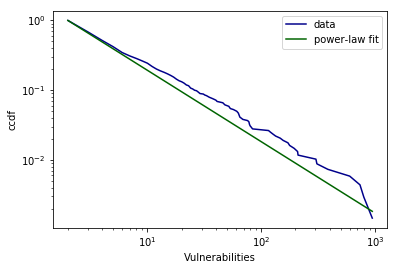

Exponential:  722.4470757879463 3.17312528088854e-15
Stretched exponential:  14.072273775566524 1.334831770271685e-07
Power law truncated:  -0.032014153127447265 0.8002387314401715
Lognormal positive:  71.5067954862364 2.1842183617568762e-14
Lognormal:  0.038748246554436094 0.5268977625662219


/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Assuming nested distributions


In [12]:
## Build and print probability distribution, bins per 10
distr = dict()
for i in values:
    bins = i // 10
    if bins in distr:
        distr[bins] += 1
    else:
        distr[bins] = 1

#for i in distr:
#    print(str(i) + ', ' + str(distr[i]))
values_fl=[]
for val in values:
    values_fl.append(float(val))

results=powerlaw.Fit(values_fl, xmin=2)
print('alpha = ',results.power_law.alpha)
print('truncated alpha = ',results.truncated_power_law.alpha)
print('xmin = ',results.power_law.xmin)
print('xmax = ',results.power_law.xmax)
print('sigma = ',results.power_law.sigma)
print('D = ',results.power_law.D)
print(results.truncated_power_law.xmin)
print('xmax = ', results.truncated_power_law.xmax)
print(results.power_law.discrete)
print('lognormal mu: ',results.lognormal.mu)
print('lognormal sigma: ',results.lognormal.sigma)

#custom_model=[]
#for i in sorted(mydata,reverse=True):
#    ccdf =

#fig=results.plot_pdf(color='b', linewidth=2)
#carlosplt.pre_paper_plot(True)
fig = results.plot_ccdf(color = 'darkblue', linestyle='-', label='data')
results.power_law.plot_ccdf(color = 'darkgreen', ax=fig, label='power-law fit')
#results.truncated_power_law.plot_ccdf(color = 'red', ax=fig)
#results.lognormal_positive.plot_ccdf(color = 'yellow', ax=fig)
#results.lognormal.plot_ccdf(color = 'brown', ax=fig)
#results.exponential.plot_ccdf(color = 'orange', ax=fig)
plt.ylabel('ccdf')
plt.xlabel('Vulnerabilities')
fig.legend()
#carlosplt.post_paper_plot(True,True,True)
plt.show()
R, p=results.distribution_compare('power_law','exponential')
print('Exponential: ',R,p)
R, p=results.distribution_compare('power_law','stretched_exponential')
print('Stretched exponential: ',R,p)
R, p=results.distribution_compare('power_law','truncated_power_law')
print('Power law truncated: ',R,p)
R, p=results.distribution_compare('power_law','lognormal_positive')
print('Lognormal positive: ',R,p)
R, p=results.distribution_compare('power_law','lognormal')
print('Lognormal: ',R,p)

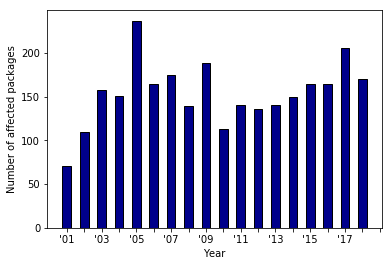

Slope: [0.30890256 0.80247773]


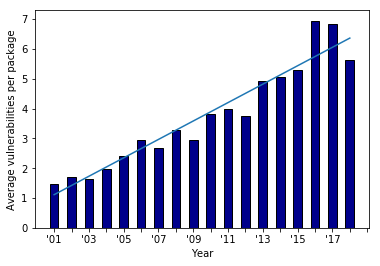

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     180.7
Date:                Thu, 31 Oct 2019   Prob (F-statistic):           3.91e-10
Time:                        13:38:58   Log-Likelihood:                -12.213
No. Observations:                  18   AIC:                             28.43
Df Residuals:                      16   BIC:                             30.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1114      0.229      4.856      0.0

In [13]:
## Number of affected packages
n = len(year_sum)
yearsx = []
for i in range(1,years+1):
    if i%2==1:
        yearsx.append('\''+str(i).zfill(2))
    else:
        yearsx.append('')
    
x = range(years)
width = 1/2
plt.bar(x, year_num[1:], width, color='darkblue', edgecolor='black')
plt.xticks(np.arange(0,n),yearsx)
plt.ylabel('Number of affected packages')
plt.xlabel('Year')
#carlosplt.post_paper_plot(True,True,True)
plt.show()

average_per_year = [0] * (years+1)
for j in range(years+1):
    try:
        average_per_year[j] = year_sum[j]/float(year_num[j])
    except ZeroDivisionError:
        average_per_year[j]=0
        
x_values = list(range(1,years+1))
slope = np.polyfit(x_values,average_per_year[1:],1)
        
print('Slope: ' + str(slope))        
n = len(year_sum)
x = range(years)
width = 1/2
#plt.bar(x, year_sum, width)
plt.bar(x, average_per_year[1:], width, color='darkblue', edgecolor='black')
plt.xticks(np.arange(0,n),yearsx)
plt.ylabel('Average vulnerabilities per package')
plt.xlabel('Year')
#carlosplt.post_paper_plot(True,True,True)
## Linear regression
X = sm.add_constant(x)
y = average_per_year[1:]
model = sm.OLS(y,X).fit()
predictions = model.predict(X)
plt.plot(predictions)
plt.show()
print(model.summary())
#print(model.summary().as_latex())

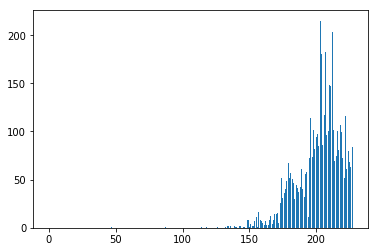

TypeError: 'int' object is not subscriptable

In [14]:
quarter_num = years*4
# Get LTS and plot

cve_once_dla=dict()

for src in src2dla:
    for dla in src2dla[src]:
        for cve in dla[0]:
            if cve not in cve_once_dla:
                year1 = dla[1][0]
                month1 = dla[1][1]
                date1 = str(year1)+'-'+str(month1)
                date1 = datetime.datetime.strptime(date1, '%Y-%m')
            try:
                date2=cvedict[cve]['Published']
                if date1<date2:
                    date=date1
                else:
                    date=date2
                cve_once_dla[cve]=date
                continue
            except KeyError:
                cve_once_dla[cve]=date1
                continue
        if cve in cve_once_dla:
            year1 = dla[1][0]
            month1 = dla[1][1]
            date1 = str(year1)+'-'+str(month1)
            date1 = datetime.datetime.strptime(date1, '%Y-%m')
            date2 = cve_once_dla[cve]
            if date1<date2:
                date=date1
            else:
                date=date2    
            cve_once_dla[cve]=date
            
## Plot for wheezy
quarter_sum = [0] * quarter_num

total_DLA=[0]*(years+1)*12

num_low_DLA = [0] * (years+1) * 12
num_med_DLA = [0] * (years+1) * 12
num_high_DLA = [0] * (years+1) * 12
num_udef_DLA = [0] * (years+1) * 12
for i in cve_once_dla:
    year = cve_once_dla[i].year
    month = cve_once_dla[i].month
    index = (year-2000)*12+month-1
    if year-2000 > years:
        continue
    total_DLA[index] += 1
    try:
        cvss=cvedict[i]['cvss']
        if cvss<0.0 or cvss>10.0:
            print('Unexpected')
            num_udef_DLA[index] += 1
        if cvss<4.0:        
            num_low_DLA[index] += 1
        elif cvss<7.0:
            num_med_DLA[index] += 1
        else:    
            num_high_DLA[index] += 1
    except:
        num_udef_DLA[index] += 1

l=1
m=1
h=1
udef=1

filtered_DLA=[0]*len(total_DLA)
        
for i in range(len(total_DLA)):
    tempp=0
    if l:
        tempp += num_low_DLA[i]
    if m:
        tempp += num_med_DLA[i]
    if h:
        tempp += num_high_DLA[i]
    if udef:
        tempp += num_udef_DLA[i]
    filtered_DLA[i]+=tempp          
        
ltslist = filtered_DLA

totalLTS = ltslist
plt.bar([i for i in range(len(ltslist))],ltslist)
plt.show()

quartersx = []
for i in range(1,years+1):
    for j in range(1,5):
        if j==1:
            quartersx.append('Q' + str(j)+'\''+str(i).zfill(2))
        else:
            quartersx.append(' ')
    
for j in range(quarter_num):
    quarter_sum[j] =  sum(total[12+(3*j):12+3*(j+1)])

LTS_quarter = []
    
for j in range(quarter_num):
    temp = sum(totalLTS[12+(3*j):12+3*(j+1)])
    LTS_quarter.append(temp)

## Print all LTS
cut = 12*4+1
n = len(quarter_sum)
x = range(quarter_num)
width = 1/2

plt.bar(x, LTS_quarter, width, color='brown', label='regular support', edgecolor='black')
plt.xticks(np.arange(0,n),quartersx, rotation="vertical")
plt.ylabel('Vulnerabilities per quarter of Debian LTS')
plt.xlabel('Quarter')
#carlosplt.post_paper_plot(True,True,True)
plt.show()
    
## Filter only wheezy:
quarter_sum_regular = [0] * (12*4+1) + quarter_sum[12*4+1:12*4+9] + [0] * 12
quarter_sum_errors = [0] * (12*4 + 9) + quarter_sum[12*4+9:12*4+9+5] + [0] * 7
LTS_quarter = [0] * (15*4+2) + LTS_quarter[15*4+2:-3]
whole_w = quarter_sum_regular[:-12] + quarter_sum_errors[12*4+9:-7] + LTS_quarter[15*4+2:]
    
#print(quarter_sum_errors)
cut = 12*4+1
n = len(quarter_sum) - cut
x = range(quarter_num-cut-3)
width = 1/2       
print(len(x))
print(len(quarter_sum_regular[cut:]))
print(len(quarter_sum_errors[cut:]))
bar1 = plt.bar(x, quarter_sum_regular[cut:], width, color='darkblue', label='regular', edgecolor='black')
bar12 = plt.bar(x, quarter_sum_errors[cut:], width, color='darkorange', label='regular*', edgecolor='black')
bar2 = plt.bar(x, LTS_quarter[cut:], width, color='darkred', label ='long-term', edgecolor='black')
plt.legend(handles=[bar1, bar12, bar2])
    
plt.xticks(np.arange(0,n),quartersx[cut:], rotation="vertical")
plt.ylabel('Vulnerabilities per quarter')
plt.xlabel('Quarter')
#carlosplt.post_paper_plot(True,True,True)
## Linear Regression
print(len(x))
print(len(whole_w[cut:]))
X = sm.add_constant(x)
y = whole_w[cut:]
model = sm.OLS(y,X).fit()
predictions = model.predict(X)
plt.plot(predictions)
plt.show()
print(model.summary())
#print(model.summary().as_latex())

In [ ]:
## Plot for wheezy ONLY HIGH severity
quarter_sum = [0] * quarter_num

l=0
m=0
h=1
udef=0

filtered_DLA=[0]*len(total_DLA)
        
for i in range(len(total_DLA)):
    tempp=0
    if l:
        tempp += num_low_DLA[i]
    if m:
        tempp += num_med_DLA[i]
    if h:
        tempp += num_high_DLA[i]
    if udef:
        tempp += num_udef_DLA[i]
    filtered_DLA[i]+=tempp          
        
ltslist = filtered_DLA

totalLTS = ltslist
plt.bar([i for i in range(len(ltslist))],ltslist)
plt.show()

quartersx = []
for i in range(1,years+1):
    for j in range(1,5):
        if j==1:
            quartersx.append('Q' + str(j)+'\''+str(i).zfill(2))
        else:
            quartersx.append(' ')
    
for j in range(quarter_num):
    quarter_sum[j] =  sum(filtered[12+(3*j):12+3*(j+1)])

LTS_quarter = []
    
for j in range(quarter_num):
    temp = sum(totalLTS[12+(3*j):12+3*(j+1)])
    LTS_quarter.append(temp)

## Print all LTS
cut = 12*4+1
n = len(quarter_sum)
x = range(quarter_num)
width = 1/2

plt.bar(x, LTS_quarter, width, color='brown', label='regular support', edgecolor='black')
plt.xticks(np.arange(0,n),quartersx, rotation="vertical")
plt.ylabel('Vulnerabilities per quarter of Debian LTS')
plt.xlabel('Quarter')
#carlosplt.post_paper_plot(True,True,True)
plt.show()
    
## Filter only wheezy:
quarter_sum_regular = [0] * (12*4+1) + quarter_sum[12*4+1:12*4+9] + [0] * 12
quarter_sum_errors = [0] * (12*4 + 9) + quarter_sum[12*4+9:12*4+9+5] + [0] * 7
LTS_quarter = [0] * (15*4+2) + LTS_quarter[15*4+2:-3]
whole_w = quarter_sum_regular[:-12] + quarter_sum_errors[12*4+9:-7] + LTS_quarter[15*4+2:]
    
#print(quarter_sum_errors)
cut = 12*4+1
n = len(quarter_sum) - cut
x = range(quarter_num-cut-3)
width = 1/2       
print(len(x))
print(len(quarter_sum_regular[cut:]))
print(len(quarter_sum_errors[cut:]))
bar1 = plt.bar(x, quarter_sum_regular[cut:], width, color='darkblue', label='regular', edgecolor='black')
bar12 = plt.bar(x, quarter_sum_errors[cut:], width, color='darkorange', label='regular*', edgecolor='black')
bar2 = plt.bar(x, LTS_quarter[cut:], width, color='darkred', label ='long-term', edgecolor='black')
plt.legend(handles=[bar1, bar12, bar2])
    
plt.xticks(np.arange(0,n),quartersx[cut:], rotation="vertical")
plt.ylabel('Vulnerabilities per quarter')
plt.xlabel('Quarter')
#carlosplt.post_paper_plot(True,True,True)
## Linear Regression
print(len(x))
print(len(whole_w[cut:]))
X = sm.add_constant(x)
y = whole_w[cut:]
model = sm.OLS(y,X).fit()
predictions = model.predict(X)
plt.plot(predictions)
plt.show()
print(model.summary())
#print(model.summary().as_latex())

In [ ]:
# Now we will plot types
root_list = ['682', '118', '330', '435', '664', '691', '693', '697', '703', '707', '710' ]

root2year=dict()
for cwe in root_list:
    root2year[cwe]=[0]*(years+1)

root2year['udef']=[0]*(years+1)

# Keep in mind that we are using the cve_once dictionary, meaning we are counting each CVE one time (rather than counting DSAs)
for cve in cve_once:
    year=cve_once[cve].year
    if year-2000 > years:
        continue
    try:
        m = re.search('(?<=CWE-)\d*', cvedict[cve]['cwe'])
        cwe=m.group(0)
        if cwe=='':
            cwe='udef'
    except:
        cwe='udef'
    try:
        myroots=cwe_roots[cwe]
    except KeyError:
        myroots=['udef']
    for root in myroots:
        root2year[root][year-2000]+=1

# Now we will do the same for both DSA and DLA. But we need months here        
root2month=dict()

for cwe in root_list:
    root2month[cwe]=[0]*(years+1)*12

root2month['udef']=[0]*(years+1)*12


for cve in cve_once:
    year=cve_once[cve].year
    month=cve_once[cve].month
    if year-2000 > years:
        continue
    try:
        m = re.search('(?<=CWE-)\d*', cvedict[cve]['cwe'])
        cwe=m.group(0)
        if cwe=='':
            cwe='udef'
    except:
        cwe='udef'
    try:
        myroots=cwe_roots[cwe]
    except KeyError:
        myroots=['udef']
    for root in myroots:
        root2month[root][(year-2000)*12+month-1]+=1


root2month_DLA=dict()

for cwe in root_list:
    root2month_DLA[cwe]=[0]*(years+1)*12

root2month_DLA['udef']=[0]*(years+1)*12


for cve in cve_once_dla:
    year=cve_once_dla[cve].year
    month=cve_once_dla[cve].month
    if year-2000 > years:
        continue
    try:
        m = re.search('(?<=CWE-)\d*', cvedict[cve]['cwe'])
        cwe=m.group(0)
        if cwe=='':
            cwe='udef'
    except:
        cwe='udef'
    try:
        myroots=cwe_roots[cwe]
    except KeyError:
        myroots=['udef']
    for root in myroots:
        root2month_DLA[root][(year-2000)*12+month-1]+=1

In [ ]:
percent = []
type_sum2year = [0]*(years+1)

for i in range(years+1):
    temp_sum = 0
    for cwe in root2year:
        temp_sum += root2year[cwe][i]
    type_sum2year[i] = temp_sum

for i in range(years+1):
    temp_year = []
    for cwe in root2year:
        try:
            temp = float(root2year[cwe][i]) / type_sum2year[i]
        except ZeroDivisionError:
            temp = 0.0
        temp_year.append(temp)
    percent.append(temp_year)
    
print(percent)
print(len(percent))
        
#carlosplt.pre_paper_plot()
x = range(2000,2000+years+1)
y = []
labels_cwe = ['682', '118', '664', '691', '693', '707', '710', 'N/A']
for i in range(12):
    if i not in [2,3,7,8]:
        y.append([j[i] for j in percent[8:]])

pal = sns.color_palette("Paired", 12)

h = plt.stackplot(x[8:], y, colors = pal, alpha=0.9, labels = labels_cwe)
plt.xticks(x[8:])
fontP = FontProperties()
fontP.set_size('small')
plt.legend(loc='upper left', handles = h[::-1], prop=fontP)
#carlosplt.post_paper_plot(True,True,True)
plt.show()


cwe_list = ['682', '118', '330', '435', '664', '691', '693', '697', '703', '707', '710', 'udef' ]

## Plot the changes in Wheezy for the top 3 types of vulnerabilities.
## Plot for wheezy
quarter_num = 4 * years
quarter_sum = dict()
quarter_sum_DLA = dict()

## DSA Q2'13-Q2'16
## DLA Q3'16-Q2'18
cwe_sum_DLA = []
for i in range(0, 12*years):
    cwe_sum_DLA.append([0]*12)
        
for cwe in root2month:
    print(cwe)
    quarter_sum[cwe] = [0] * quarter_num
    quarter_sum_DLA[cwe] = [0] * quarter_num
    for m in range(quarter_num):
        quarter_sum[cwe][m] = root2month[cwe][3*m] + root2month[cwe][3*m+1] + root2month[cwe][3*m+2]
        quarter_sum_DLA[cwe][m] = root2month_DLA[cwe][3*m] + root2month_DLA[cwe][3*m+1] + root2month_DLA[cwe][3*m+2]

print(quarter_sum)
print(quarter_sum_DLA)
quartersx = []
for i in range(1,years+1):
    for j in range(1,5):
        if j==1:
            quartersx.append('Q' + str(j)+'\''+str(i).zfill(2))
        else:
            quartersx.append(' ')

fig = plt.figure()
ii = 0
for j in [1, 4, 6, 11]:
    cwe=cwe_list[j]
    ii += 1
    quarter_sum_regular = [0] * (12*4+1) + quarter_sum[cwe][12*4+1:12*4+9] + [0] * 12
    quarter_sum_errors = [0] * (12*4 + 9) + quarter_sum[cwe][12*4+9:12*4+9+5] + [0] * 7
    LTS_quarter = [0] * (15*4+2) + quarter_sum_DLA[cwe][15*4+2:-3]
    #print(quarter_sum_errors)
    cut = 12*4+1
    n = len(quarter_sum[cwe]) - cut -3
    x = range(quarter_num-cut-3)
    width = 1/2
    #print(len(LTS_quarter))
    print(len(x))
    print(len(quarter_sum_regular[cut:]))
    print(len(quarter_sum_errors[cut:]))
    print(len(LTS_quarter[cut:]))
    ax = fig.add_subplot(2,2,ii)            
    bar1 = plt.bar(x, quarter_sum_regular[cut:], width, color='darkblue', label='regular', edgecolor='black')
    bar12 = plt.bar(x, quarter_sum_errors[cut:], width, color='darkorange', label='regular*', edgecolor='black')
    bar2 = plt.bar(x, LTS_quarter[cut:], width, color='darkred', label ='long-term', edgecolor='black')
    if ii==2:
        plt.legend(handles=[bar1, bar12, bar2])
    plt.xticks(np.arange(0,n),quartersx[cut:], rotation="vertical")
    try:
        plt.ylabel('CWE-' + root_list[j])
    except IndexError:
        plt.ylabel('N/A')
        plt.xlabel('Quarter')
#carlosplt.post_paper_plot(True,True,True)
plt.show()